# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import scanpy as sc

from importlib import reload
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Load Data

We recommend the use of scanpy Anndata objects as the preferred mode of loading and filtering data.

A sample dataset is provided and can be accessed using the ```load_data()``` method

In [4]:
from metacells.utils import load_data

In [5]:
ad = load_data()

# Pre-processing

The following section describes basic pre-processing steps for scRNA-seq. For scATAC-seq, we provide a pipeline for pre-processing in  in example notebook `preprocessing-ATAC.ipynb`

In [6]:
# First we remove any genes which have counts for fewer than 5 cells
non_zero_entries =  np.count_nonzero(ad.to_df(), axis=0)
keep_genes = ad.var_names[non_zero_entries>=5]
ad = ad[:, keep_genes]

# We drop any cells with zero expression as well
keep_cells = ad.obs_names[ad.to_df().sum(1) > 0]
ad = ad[keep_cells, :]

In [7]:
# We now generate principal components, which will be later used to run Metacells.
# 

# Normalize cells and compute highly variable genes
sc.pp.normalize_per_cell(ad)
sc.pp.highly_variable_genes(ad)

# Compute principal components - 
# Here we use 50 components. This number may also be selected by examining variance explaint
sc.tl.pca(ad, n_comps=50, use_highly_variable=True)

Trying to set attribute `.obs` of view, copying.


# Running Metacells

In [8]:
## User defined parameters

## Core parameters 
n_metacells = 10
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells
waypoint_proportion = 1 # Proportion of metacells to initialize using waypoint analysis, 
                        # the remainder of cells are selected by greedy selection




In [9]:
from metacells.core import Metacells
from sklearn.metrics import silhouette_score


model = Metacells(ad, 
                  build_kernel_on=build_kernel_on, 
                  n_metacells=n_metacells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

model.fit(n_iter=100)


Building kernel...
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...



Making graph symmetric...
Computing RBF kernel...



Building similarity LIL matrix...



Constructing CSR matrix...
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Initializing residual matrix using greedy column selection
Initializing f and g...



Selecting 9 cells from waypoint initialization.
Selecting 1 cells from greedy initialization.
Setting convergence threshold at 0.004933527767379396
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Starting iteration 40.
Completed iteration 40.
Starting iteration 50.
Completed iteration 50.
Starting iteration 60.
Completed iteration 60.
Starting iteration 70.
Completed iteration 70.
Starting iteration 80.
Completed iteration 80.
Starting iteration 90.
Completed iteration 90.
Starting iteration 100.
Completed iteration 100.
Converged after 100 iterations.


# Accessing results

### Model Parameters

The Metacells model oject has the following attributes

### Model Convergence

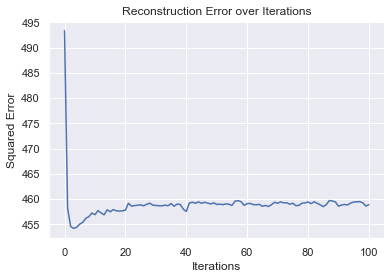

In [10]:
%matplotlib inline
# Check for convergence 
model.plot_convergence()

### Metacell Labels

These can be accessed as folows:
- in the modified anndata object in `.obs['Metacell']`
- from the model using `.get_assignments()`


In [11]:
ad.obs['Metacell'].head()

index
cd34_multiome_rep1#AAACAGCCACTCGCTC-1    cd34_multiome_rep1#AAAGCACCACCAGCAT-1
cd34_multiome_rep1#AAACAGCCACTGACCG-1    cd34_multiome_rep1#AAAGCGGGTATTCGCT-1
cd34_multiome_rep1#AAACAGCCATAATCAC-1    cd34_multiome_rep1#ACCCGTAAGCACCACA-1
cd34_multiome_rep1#AAACATGCAAATTCGT-1    cd34_multiome_rep1#ACCCGTAAGCACCACA-1
cd34_multiome_rep1#AAACATGCAGCATGTC-1    cd34_multiome_rep1#AATGAAGGTAGCTGGT-1
Name: Metacell, dtype: object

In [12]:
model.get_assignments().head()

,Metacell
index,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,cd34_multiome_rep1#AAAGCACCACCAGCAT-1
cd34_multiome_rep1#AAACAGCCACTGACCG-1,cd34_multiome_rep1#AAAGCGGGTATTCGCT-1
cd34_multiome_rep1#AAACAGCCATAATCAC-1,cd34_multiome_rep1#ACCCGTAAGCACCACA-1
cd34_multiome_rep1#AAACATGCAAATTCGT-1,cd34_multiome_rep1#ACCCGTAAGCACCACA-1
cd34_multiome_rep1#AAACATGCAGCATGTC-1,cd34_multiome_rep1#AATGAAGGTAGCTGGT-1


# Summarizing data

- `.summarize_by_metacell()`

Datasets can be summarized by metacell by aggregating cells within each metacell - either averaging or summing over all raw data for all cells belonging to a metacell. The output of this function is an anndata object of shape n_metacells x original_data_dimension 



In [13]:
metacell_ad = model.summarize_by_metacell(aggregate_by='sum')
metacell_ad

Summing features for each metacell.


AnnData object with n_obs × n_vars = 10 × 14273
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'Metacell_Entropy'

# Evaluating Results

We provide several methods for evaluating metacell assignments:

## 1.Visualizing Results

Metacells also implements methods for visualizing the results of the Metacells algorithm 
    <ul> 
        <li>```.plot_2D()``` provides an interface for viewing metacell assignments on any 2-dimensional embedding in ad.obsm. Plots can also be coloured by metacell assignment.
        <li>```.plot_metacell_sizes()``` can be used to view the distribution of number of cells assigned to each metacell
        <li>```.plot_assignment_entropy(ad)``` returns the entropy of assignment probabilities across metacells for each metacell. These values should ideally be low, indicating strong memmbership within a metacell. This function also optionally plots the entropy distribution.
    </ul>
    
            

In [15]:
# Load the plotting functions as plot
from metacells import plot
sns.set(style="white")

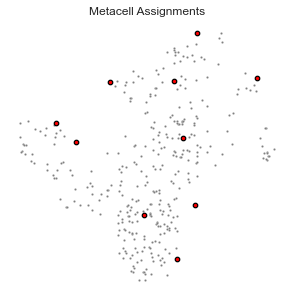

In [16]:
plot.plot_2D(ad, key='X_umap', colour_metacells=False)

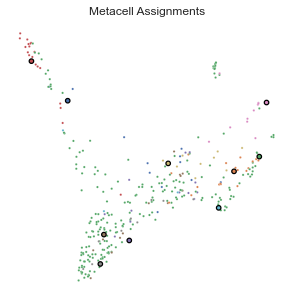

In [17]:
plot.plot_2D(ad, key = 'X_FDL', colour_metacells=True)

/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


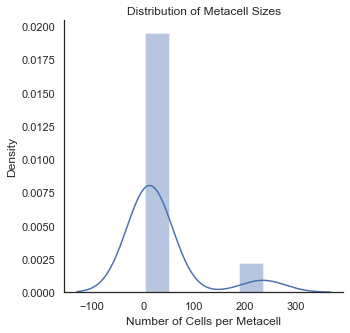

Metacell
cd34_multiome_rep1#AAAGCACCACCAGCAT-1     13
cd34_multiome_rep1#AAAGCGGGTATTCGCT-1     19
cd34_multiome_rep1#AAGTTACGTCATGAGC-1      4
cd34_multiome_rep1#AATAGCTGTAACCACA-1     14
cd34_multiome_rep1#AATCCCTGTCAAGTAT-1     10
cd34_multiome_rep1#AATGAAGGTAGCTGGT-1     21
cd34_multiome_rep1#ACACTTGCAATGCGCT-1     10
cd34_multiome_rep1#ACATAGCTCATTATGG-1     13
cd34_multiome_rep1#ACCCGTAAGCACCACA-1    235
cd34_multiome_rep1#ACTAACTCAAACAACA-1     11
Name: index, dtype: int64

In [18]:
plot.plot_metacell_sizes(ad, bins=5)

/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


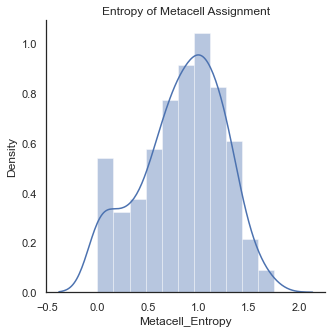

In [19]:
plot.plot_assignment_entropy(ad)

... storing 'Metacell' as categorical


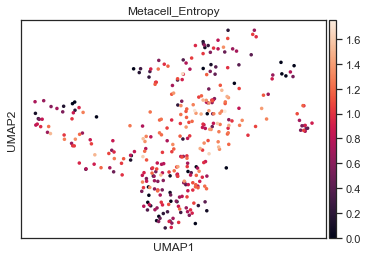

In [20]:
# This entropy can be visualized in 2D using standard scanpy plotting functions, as well
sc.pl.umap(ad, color='Metacell_Entropy',s=50)

## 2. Quantifying Results

Metacells also implements methods for visualizing the results of the Metacells algorithm 
    <ul> 
        <li>```.compute_within_metacell_entropy(ad, cluster, plot=True``` computes the entropy of different cluster labels within a Metacell. Typically, we use cluster='celltype' or similar, to visualize how well metacells represent subpopulations within a single cluster. This returns a pd.DataFrame of length n_metacells with the entropy of the distribution of cluster labels within each metacell.
        <li>```.get_metacell_compactness(ad, per_metacell=True, low_density_cells=False)``` computes the per-metacell average negative log-likelihood of cells being generated by their assigned metacell. Lower values of compactness suggest more compact/lower variance metacells. We can subset to only low density cells (computed as described in ```evaluate.get_density()```) to specific see performance in less dense regions or set per_metacell=False to see per-cell values.
        <li>```.get_metacell_separation(ad, nbr=k, per_metacell=True, low_density_cells=False)``` computes the (per-metacell average of) the difference in negative log-likelihood of cells being generated by their kth nearest-neighbor metacell and their assigned metacell. Higher values of separation suggest better distinction between metacells. We can subset to only low density cells (computed as described in ```evaluate.get_density()```) to specific see performance in less dense regions or set per_metacell=False to see per-cell values.
    </ul>
    


In [21]:
from metacells import evaluate

sns.set(style='white')
%matplotlib inline

In [22]:
within_mc_entropy = evaluate.compute_within_metacell_entropy(ad, 'celltype')
within_mc_entropy.head()

,entropy
cd34_multiome_rep1#AAAGCACCACCAGCAT-1,1.031767
cd34_multiome_rep1#AAAGCGGGTATTCGCT-1,0.514653
cd34_multiome_rep1#ACCCGTAAGCACCACA-1,1.621820
cd34_multiome_rep1#AATGAAGGTAGCTGGT-1,0.380506
cd34_multiome_rep1#ACATAGCTCATTATGG-1,1.072017


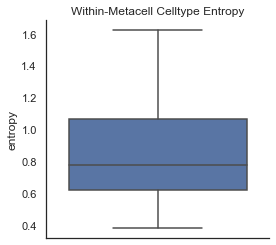

In [23]:

plt.figure(figsize=(4,4))
sns.boxplot(data=within_mc_entropy, y='entropy')
plt.title('Within-Metacell Celltype Entropy')
sns.despine()
plt.show()
plt.close()

In [24]:
import palantir 

neighbours, NLL_df = evaluate.get_NLLs(ad)
metacell_compactness = evaluate.get_compactness(ad, low_density_cells=False, per_metacell=True)


Computing 5 neighbours in diffusion component space and Gaussian from X_pca space.
Determing nearest neighbor graph...
Clipping to metacells with at least 3 cells.
Dropping 0 metacell(s) due to insufficient size.
Clipping to metacells with at least 3 cells.
Dropping 0 metacell(s) due to insufficient size.
Computing 5 neighbours in diffusion component space and Gaussian from X_pca space.
Determing nearest neighbor graph...


In [25]:
metacell_compactness_low_density = evaluate.get_compactness(ad, low_density_cells=True, per_metacell=True)

Computing cell densities.
Using PCA
Determing nearest neighbor graph...


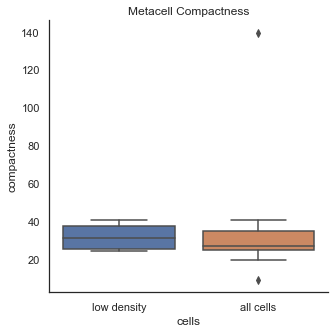

In [26]:
metacell_compactness['cells'] = 'all cells'
metacell_compactness_low_density['cells'] = 'low density'

compactness = pd.concat([metacell_compactness_low_density, metacell_compactness], axis=0)

plt.figure(figsize=(5,5))
sns.boxplot(data=compactness, x='cells', y='compactness')
sns.despine()
plt.title('Metacell Compactness')
plt.show()
plt.close()

In [27]:
metacell_separation = evaluate.get_separation(ad, low_density_cells=False, per_metacell=True)


In [28]:
metacell_separation_low_density = evaluate.get_separation(ad, low_density_cells=True, per_metacell=True)


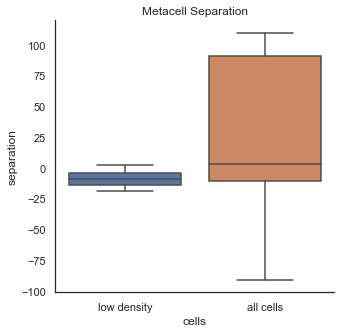

In [29]:
metacell_separation['cells'] = 'all cells'
metacell_separation_low_density['cells'] = 'low density'

separation = pd.concat([metacell_separation_low_density, metacell_separation], axis=0)

plt.figure(figsize=(5,5))
sns.boxplot(data=separation, x='cells', y='separation')
sns.despine()
plt.title('Metacell Separation')
plt.show()
plt.close()